In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
import matplotlib.pyplot as plt


drive.mount('/content/drive')
torch.set_default_dtype(torch.float32)

In the end it was difficult to extract meaningful signal from the damage dataset, so we will instead focus on character classification.

# Loading the data and setting up a train/test split

In [20]:
df = pd.read_pickle('/content/drive/MyDrive/colorData.pkl')

In [26]:
df.drop(columns=['Move'], inplace=True)
trainSet=df.sample(frac=0.8,random_state=11)
testSet=df.drop(trainSet.index).reset_index()
trainSet = trainSet.reset_index()

# Creating dataset and neural network classes

In [27]:
class GIFDatasetFromDF(Dataset):
    def __init__(self, dataframe, label_map):
        self.dataframe = dataframe
        self.label_map = label_map  # Dictionary mapping class names to indices

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the row corresponding to the index
        row = self.dataframe.iloc[idx]

        # Extract the tensor and label
        gif_tensor = row['Tensor']  # The GIF tensor with shape [3, 60, 128, 128]
        label_name = row['Name']  # The target label (string)
        label = torch.tensor(self.label_map[label_name])  # Convert label to tensor index

        return gif_tensor, label

In [28]:
class_names = sorted(df['Name'].unique())
label_map = {name: idx for idx, name in enumerate(class_names)}
reverse_label_map = {v:k for k,v in label_map.items()}


dataset = GIFDatasetFromDF(trainSet, label_map)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [29]:
class GIFClassifierCNN(nn.Module):
    def __init__(self, num_classes=26):
        super(GIFClassifierCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), stride=1, padding=1)

        # Pooling layer (3D pooling to reduce temporal and spatial dimensions)
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))  # Output: [batch_size, 64, 30, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # Output: [batch_size, 128, 15, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))  # Output: [batch_size, 256, 7, 16, 16]

        # Flatten the output for the fully connected layers
        x = x.view(-1, 256 * 7 * 16 * 16)

        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        # Output layer
        x = self.fc3(x)


        return x

# Example usage:
# Create the model
model = GIFClassifierCNN(num_classes=26)

# Print the model architecture
print(model)

# Create a random tensor with the specified shape [batch_size, 3, 60, 128, 128]
input_tensor = torch.randn(2, 3, 60, 128, 128)

# Forward pass through the model
output = model(input_tensor)

# Output should be of shape [batch_size, 26] corresponding to the class scores
print(output.shape)

GIFClassifierCNN(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=458752, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=26, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
torch.Size([2, 26])


# Training the model

Let's train our CNN, after testing a variety of learning rates, it seems like a small learning rate performs very well with this task. We will be using the cross entropy loss for this classification problem.

In [34]:
def train(model, dataloader, num_epochs=10, learning_rate=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data

            # Move to GPU if available
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
                model = model.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 10 == 9:  # Print every 10 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

    print('Finished Training')


model = GIFClassifierCNN(num_classes=26)


train(model, dataloader, num_epochs=25, learning_rate=0.00001)

Epoch [1/25], Step [10/67], Loss: 7.5225
Epoch [1/25], Step [20/67], Loss: 6.1788
Epoch [1/25], Step [30/67], Loss: 4.0932
Epoch [1/25], Step [40/67], Loss: 3.3673
Epoch [1/25], Step [50/67], Loss: 3.2927
Epoch [1/25], Step [60/67], Loss: 3.1532
Epoch [2/25], Step [10/67], Loss: 2.9780
Epoch [2/25], Step [20/67], Loss: 2.8838
Epoch [2/25], Step [30/67], Loss: 2.9367
Epoch [2/25], Step [40/67], Loss: 2.8327
Epoch [2/25], Step [50/67], Loss: 2.9475
Epoch [2/25], Step [60/67], Loss: 2.8187
Epoch [3/25], Step [10/67], Loss: 2.7067
Epoch [3/25], Step [20/67], Loss: 2.5290
Epoch [3/25], Step [30/67], Loss: 2.6311
Epoch [3/25], Step [40/67], Loss: 2.6100
Epoch [3/25], Step [50/67], Loss: 2.4633
Epoch [3/25], Step [60/67], Loss: 2.7153
Epoch [4/25], Step [10/67], Loss: 2.3780
Epoch [4/25], Step [20/67], Loss: 2.1652
Epoch [4/25], Step [30/67], Loss: 2.3042
Epoch [4/25], Step [40/67], Loss: 2.2448
Epoch [4/25], Step [50/67], Loss: 2.0882
Epoch [4/25], Step [60/67], Loss: 2.0641
Epoch [5/25], St

Let's get a quick accuracy score on the test set, and load up some actual and predicted lists for finer grained comparison

In [89]:
actual = []
predicted = []
accuracy = []
model.eval()
for i in range(len(testSet['Tensor'])):
    input = testSet['Tensor'][i]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input= input.to(device)
    with torch.no_grad():
        outputs = model(input)

        # Get probabilities using softmax
        probabilities = F.softmax(outputs, dim=1)

        # Get the predicted class
        _, predicted_class = torch.max(probabilities, 1)

        actual.append(testSet['Name'][i])
        predicted.append(reverse_label_map[predicted_class.item()])
        if  str(testSet['Name'][i]) == reverse_label_map[predicted_class.item()]:
            accuracy.append(1)
        else:
            accuracy.append(0)
sum(accuracy)/len(accuracy)

0.7180451127819549

This seems to be doing quite well! Let's look at the confusion matrix for an overall picture on what the errors look like.

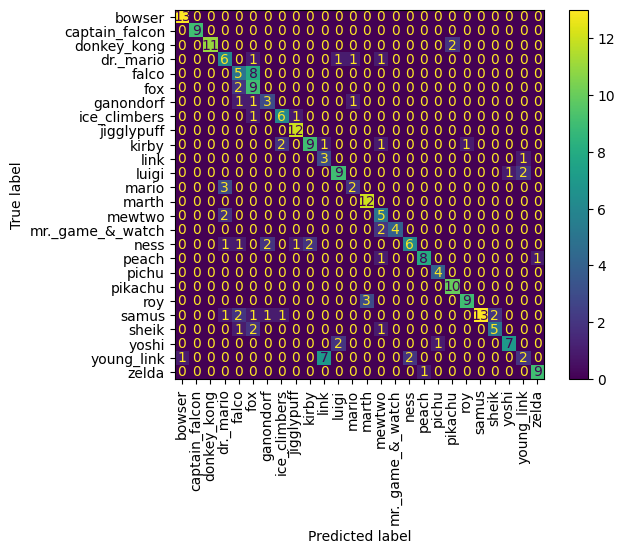

In [91]:
cm = confusion_matrix(actual, predicted, labels=testSet['Name'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testSet['Name'].unique() )
disp.plot()
plt.xticks(rotation=90)
plt.show()

As we can see, most of the errors are coming from the models difficulty in distinguishing the characters 'Link' and 'Young Link.' As these are the same character at two different points in time, I will give the model a pass here!